# Waddington OT data Loader

This notebook shows how to load the data from the Schiebinger et al. 2019 paper:

G. Schiebinger, J. Shu, M. Tabaka, B. Cleary, V. Subramanian, A. Solomon, J. Gould, S. Liu, S. Lin, P. Berube, L. Lee, J. Chen, J. Brumbaugh, P. Rigollet, K. Hochedlinger, R. Jaenisch, A. Regev, E. S. Lander, Optimal-Transport Analysis of Single-Cell Gene Expression Identifies Developmental Trajectories in Reprogramming. Cell. 176, 928-943.e22 (2019).

The data can be accessed here:
https://broadinstitute.github.io/wot/

It also shows how to save the data in a format that can be loaded in TrajectoryNet. TrajectoryNet requires the following:
1. An embedding matrix titled `[embedding_name]` (Cells x Dimensions)
2. A sample labels array titled `sample_labels` (Cells)
3. (Optionally) a delta embedding representing RNA velocity titled `delta_[embedding_name]` (Cells x Dimensions)

These are saved in as numpy arrays in a (compressed) numpy dictionary. The TrajectoryNet paper uses both the PHATE and PCA embeddings, though arbitrary embeddings can be used. Invertible embeddings are useful to invert the paths back to the feature space. Embeddings should be named so the name can be supplied as an argument to TrajectoryNet.

In TrajectoryNet we used library size normalized (to 10,000 counts per cell) and square root transformed counts. When performed on PCA space this corresponds to approximate optimal transport with an L1 ground metric. While nice mathematically, this is fairly inconsequential. Log transformed counts seem to perform equivalently well.

In TrajectoryNet we whitened (i.e. set mean=0, variance=1 in all dimensions) to all embeddings before the neural network. We found that this helps with the optimization. Neural networks are generally initialized to accept inputs in this approximate range. We recommend keeping most of your features in this range if possible. Depending on your application it may make sense to omit this step, or only normalize to the maximally varying dimensions.



In [1]:
import scprep
import phate
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scanpy
import os

In [2]:
PATH = '/data/lab/DataSets/Schiebinger_2019_OT/'

In [3]:
# Path to input files
FLE_COORDS_PATH ='data/fle_coords.txt'
FULL_DS_PATH = 'data/ExprMatrix.h5ad'
VAR_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = 'data/cell_days.txt'
GENE_SETS_PATH = 'data/gene_sets.gmx'
GENE_SET_SCORES_PATH = 'data/gene_set_scores.csv'
CELL_SETS_PATH = 'data/cell_sets.gmt'

coord_df = pd.read_csv(PATH+FLE_COORDS_PATH, index_col='id', sep='\t')
days_df = pd.read_csv(PATH+CELL_DAYS_PATH, index_col='id', sep='\t')

In [4]:
gene_set_df = pd.read_csv(PATH+GENE_SET_SCORES_PATH)

In [5]:
gene_set_df.columns

Index(['id', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress',
       'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP',
       'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN',
       'Trophoblast', 'Trophoblast progenitors',
       'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts',
       'Oligodendrocyte precursor cells (OPC)', 'Astrocytes',
       'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10',
       'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme',
       'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed',
       '2-cell', '4-cell', '8-cell', '16-cell', '32-cell'],
      dtype='object')

In [6]:
adata = scanpy.read_h5ad(PATH+FULL_DS_PATH)

In [7]:
mask = [ind in days_df.index for ind in coord_df.index]

Text(0.5, 1.0, 'Day')

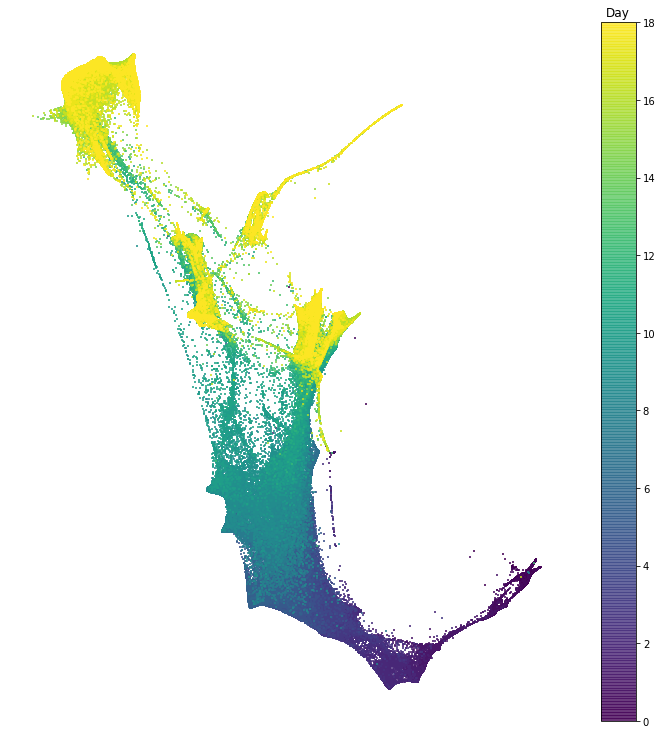

In [8]:
unique_days = days_df['day'].unique()
unique_days = unique_days[np.isnan(unique_days) == False]
# plot visualization coordinates
figure = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.tight_layout()
plt.scatter(coord_df[mask]['x'], coord_df[mask]['y'],c=days_df['day'],
               s=4, marker=',', edgecolors='none', alpha=0.8)
cb = plt.colorbar()
cb.ax.set_title('Day')

/home/atong/.local/lib/python3.8/site-packages/scprep/utils.py:199: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/home/atong/.local/lib/python3.8/site-packages/scprep/utils.py:201: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(x, pd.SparseSeries):
/home/atong/.local/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(


<AxesSubplot:xlabel='x', ylabel='y'>

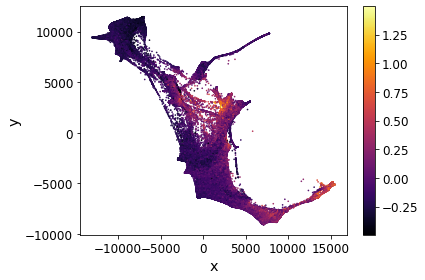

In [9]:
scprep.plot.scatter(coord_df['x'], coord_df['y'],c=gene_set_df['MEF.identity'],)

In [10]:
df = adata.to_df()

/home/atong/.local/lib/python3.8/site-packages/scprep/utils.py:244: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/home/atong/.local/lib/python3.8/site-packages/scprep/utils.py:268: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.DataFrame) and not isinstance(x, pd.SparseDataFrame):
/home/atong/.local/lib/python3.8/site-packages/scprep/plot/histogram.py:154: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("symlog", linthreshx=abs_min)


<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

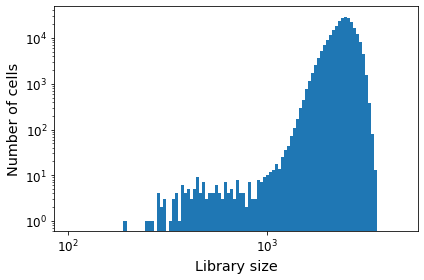

In [11]:
scprep.plot.plot_library_size(df)

In [12]:
df = scprep.normalize.library_size_normalize(df)

/home/atong/.local/lib/python3.8/site-packages/scprep/utils.py:268: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.DataFrame) and not isinstance(x, pd.SparseDataFrame):
/home/atong/.local/lib/python3.8/site-packages/scprep/normalize.py:73: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.SparseDataFrame):


In [13]:
df = scprep.transform.sqrt(df)

/home/atong/.local/lib/python3.8/site-packages/scprep/utils.py:550: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/home/atong/.local/lib/python3.8/site-packages/scprep/utils.py:268: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.DataFrame) and not isinstance(x, pd.SparseDataFrame):
/home/atong/.local/lib/python3.8/site-packages/scprep/utils.py:322: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if is_sparse_dataframe(data) or isinstance(data, pd.SparseDataFrame):


In [ ]:
phate_op = phate.PHATE(n_jobs=-2, k=25, random_state=42)
data_phate = phate_op.fit_transform(df)

Calculating PHATE...
  Running PHATE on 251203 observations and 19089 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1080.68 seconds.
    Calculating KNN search...


In [ ]:
scprep.plot.scatter2d(data_phate[mask],
                      ticks=False,
                      c=days_df['day'])

In [ ]:

scprep.plot.scatter2d(data_phate, c=gene_set_df['MEF.identity'])

In [ ]:
scprep.plot.scatter2d(phate_op.graph.data_nu[mask], c=days_df['day'])

In [ ]:
scprep.plot.scatter2d(phate_op.graph.data_nu[mask], figsize=(16,9), c=days_df['day'])

In [ ]:
scprep.plot.scatter2d(coord_df[mask], 
                      #figsize=(16,9), 
                      ticks=False,
                      c=days_df['day'])

In [ ]:
to_save = {
    'pcs': phate_op.graph.data_nu[mask],
    'original_embedding': np.array(coord_df)[mask],
    'phate' : data_phate[mask],
    'sample_labels' : np.array(days_df['day']),
}
np.savez('../data/schiebinger.npz', **to_save)

In [ ]:
np.unique(to_save['sample_labels'])